<h1>This notebook contains code to plot mean Decorrealtion time-series<h1>

<h2>STEP 1<h2>
    <blockquote>installing necessary libraries and dependancies

In [1]:
# Install necessary libraries
#!pip install geopandas matplotlib rasterio numpy pandas pathlib

# Import the necessary libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd
from pathlib import Path

<h2>STEP 2<h2>
<blockquote>We need to define fuctions to (a) load and display shapefiles we will use, (b)check and transform coordinate reference system if there is any mismatch (c) extract coherence values values

In [2]:
def load_and_display_shapefile(shapefile_path):
    try:
        shapes = gpd.read_file(shapefile_path)
        if not shapes.empty:
            print("Shapefile loaded successfully. Displaying contents:")
            print(shapes)
            # Plot the shapefile
            shapes.plot()
            plt.show()
        else:
            print("Shapefile loaded but contains no data.")
        return shapes
    except Exception as e:
        print(f"Failed to load shapefile: {e}")
        return None

In [3]:
def check_and_transform_crs(shapes, raster_crs):
    if shapes.crs != raster_crs:
        print(f"Transforming shapefile CRS from {shapes.crs} to {raster_crs}")
        shapes = shapes.to_crs(raster_crs)
    return shapes

In [4]:
def extract_polygonwise_coherence(raster_files, shapes):
    data_cube = {}
    for raster_file in raster_files:
        with rasterio.open(raster_file) as src:
            raster_crs = src.crs
            shapes = check_and_transform_crs(shapes, raster_crs)

            raster_name = raster_file.stem
            polygon_values = []
            for geom in shapes.geometry:
                try:
                    # Mask the raster with the polygon
                    out_image, out_transform = rasterio.mask.mask(src, [geom], crop=True)
                    out_image = out_image[0]  # Assuming single band raster
                    
                    # Extract valid values
                    valid_values = out_image[out_image > 0]
                    
                    # Calculate mean coherence value within the polygon
                    if valid_values.size > 0:
                        mean_value = valid_values.mean()  # Ignore zero values if any
                    else:
                        mean_value = np.nan
                    polygon_values.append(mean_value)
                except Exception as e:
                    print(f"Error processing polygon in {raster_name}: {e}")
                    polygon_values.append(np.nan)
            
            # Store the values in the data cube with raster name as the key
            data_cube[raster_name] = polygon_values
    
    return data_cube

<h2>Define the path to shapefile, list the raster files containing NDVI data in tif format<h2>
    <blockquote>which is pre-downloaded and renamed and kept in separate folder 

In [5]:
# Define the path to the shapefile
shapefile_path = Path.home() / "PGD_Project" / "individual_plots_7_combined" / "final_7_plots.shp"

In [6]:
# List of raster files
raster_files = [ Path.home() / "PGD_Project" / "coherence_raster" / fname for fname in [
    "2023Jan08_2023Feb01.tif",
    "2023Feb01_2023Feb13.tif",
    "2023Feb13_2023Feb25.tif",
    "2023Feb25_2023Apr26.tif",
    "2023Apr26_2023May20.tif",
    "2023May20_2023Jun01.tif",
    "2023Jun01_2023Jun13.tif",
    "2023Jun13_2023Jun25.tif",
    "2023Jun25_2023Jul07.tif",
    "2023Jul07_2023Jul19.tif",
    "2023Jul19_2023Jul31.tif",
    "2023Jul31_2023Aug12.tif",
    "2023Aug12_2023Aug24.tif",
    "2023Aug24_2023Sep05.tif",
    "2023Sep05_2023Sep17.tif",
    "2023Sep17_2023Oct11.tif",
    "2023Oct11_2023Oct23.tif",
    "2023Oct23_2023Nov04.tif",
    "2023Nov04_2023Nov16.tif"
]]

Shapefile loaded successfully. Displaying contents:
  Name descriptio timestamp begin   end altitudeMo  tessellate  extrude  \
0   P1       None      None  None  None       None           1        0   
1   P2       None      None  None  None       None           1        0   
2   P3       None      None  None  None       None           1        0   
3   P4       None      None  None  None       None           1        0   
4   P5       None      None  None  None       None           1        0   
5   P6       None      None  None  None       None           1        0   
6   P7       None      None  None  None       None           1        0   

   visibility drawOrder  icon  \
0          -1      None  None   
1          -1      None  None   
2          -1      None  None   
3          -1      None  None   
4          -1      None  None   
5          -1      None  None   
6          -1      None  None   

                                            geometry  
0  POLYGON Z ((78.12805 30.

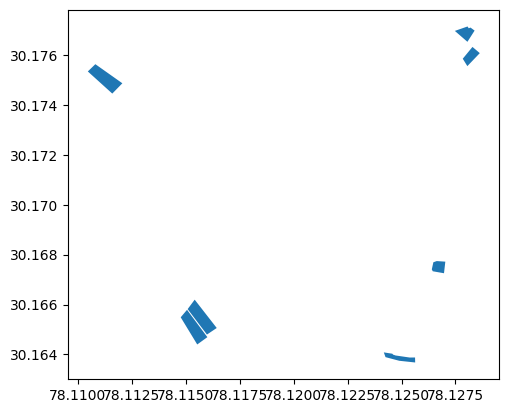

In [7]:
# Load and display the shapefile
shapes = load_and_display_shapefile(shapefile_path)

In [8]:
# Extract polygon-wise coherence values and store them in a data cube
data_cube = extract_polygonwise_coherence(raster_files, shapes)

Transforming shapefile CRS from epsg:4326 to EPSG:32644


In [9]:
# Convert the data cube to a DataFrame for easier analysis and visualization
df = pd.DataFrame(data_cube, index=[f'Polygon_{i}' for i in range(len(shapes))])

In [10]:
# Display the DataFrame
print(df)

           2023Jan08_2023Feb01  2023Feb01_2023Feb13  2023Feb13_2023Feb25  \
Polygon_0             0.375166             0.647982             0.816955   
Polygon_1             0.768959             0.743990             0.835741   
Polygon_2             0.791728             0.642277             0.774686   
Polygon_3             0.507345             0.668660             0.759369   
Polygon_4             0.153479             0.330179             0.524747   
Polygon_5             0.208717             0.277616             0.617489   
Polygon_6             0.321668             0.266804             0.478874   

           2023Feb25_2023Apr26  2023Apr26_2023May20  2023May20_2023Jun01  \
Polygon_0             0.727446             0.574333             0.423097   
Polygon_1             0.770284             0.653787             0.734324   
Polygon_2             0.586910             0.794512             0.769992   
Polygon_3             0.569182             0.683879             0.600294   
Polygon_4  

In [11]:
# Optionally, save the DataFrame to a CSV file
df.to_csv(Path.home() / "PGD_Project" / "coherence_values_allplots.csv", index=True)

<h3>Plot the Data

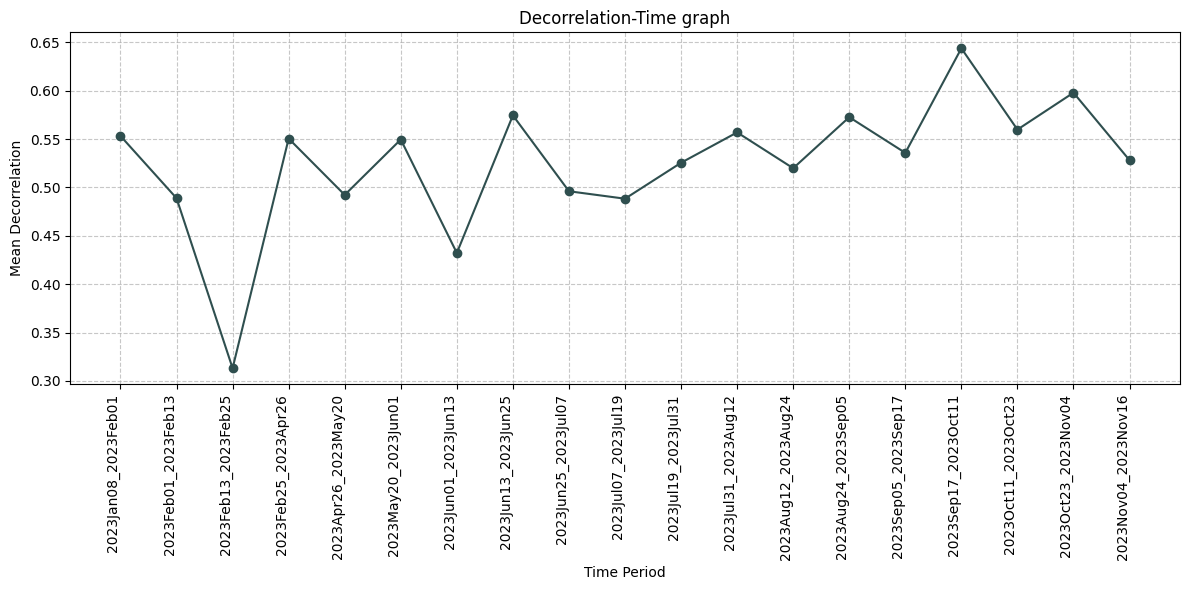

In [13]:
# Calculate the mean of each column, excluding NaN values
mean_values = df.mean(skipna=True)

# Calculate decorrelation as negative of mean correlation
decorrelation = 1-mean_values

# Create a list of dates from the column names
dates = decorrelation.index.tolist()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(dates, decorrelation.values, marker='o', color='darkslategrey')
plt.title('Decorrelation-Time graph')
plt.xlabel('Time Period')
plt.ylabel('Mean Decorrelation')
plt.xticks(rotation=90, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()